Compare to P-Net:


|                         | accuracy | auc      | aupr     | f1       | precision | recall   |
|-------------------------|----------|----------|----------|----------|-----------|----------|
| P-net_ALL               | 0.838235 | 0.926789 | 0.878182 | 0.755556 | 0.750000  | 0.761194 |
| Logistic Regression_ALL | 0.833333 | 0.881904 | 0.808983 | 0.725806 | 0.789474  | 0.671642 |

In [ ]:
import time
import os

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from cancernet.arch import GATNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet

## Load dataset

In [ ]:
dataset = PnetDataSet(
    root=os.path.join("data", "prostate"),
    name="prostate_graph_humanbase",
    # files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

Ensure consistent and reproducible train/validation/test split.

In [ ]:
splits_root = os.path.join("data", "prostate", "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [ ]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15080, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [ ]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

## Train

Set up hyperparameters and random seed.

In [ ]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.01

Global seed set to 42


Prepare data.

In [ ]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Create and train model.

Train.

In [ ]:
t0 = time.time()

model = GATNet(dims=[3, 64, 256, 128], lr=lr)
logger = InMemoryLogger()
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=50, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(
    dirpath="model_ckpts",
    monitor="val_loss",
    save_top_k=1,
    filename="bestmodel_gat",
    mode="min",
)
bestmodel_file = os.path.join("model_ckpts", "bestmodel_gat.ckpt")
if os.path.isfile(bestmodel_file):
    os.remove(bestmodel_file)

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar(), early_stop_callback, checkpoint_callback],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | prop1   | GCNConv         | 256   
1 | prop2   | GCNConv         | 16.6 K
2 | fc1     | Linear          | 32.9 K
3 | fc2     | Linear          | 258   
4 | m       | LogSoftmax      | 0     
5 | gate_nn | Sequential      | 8.3 K 
6 | pool    | GlobalAttention | 8.3 K 
--------------------------------------------
58.3 K    Trainable params
0         Non-trainable params
58.3 K    Total params
0.233     Total estimated model params size (MB)
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training took 152.2 seconds.


Visualize training trajectory.

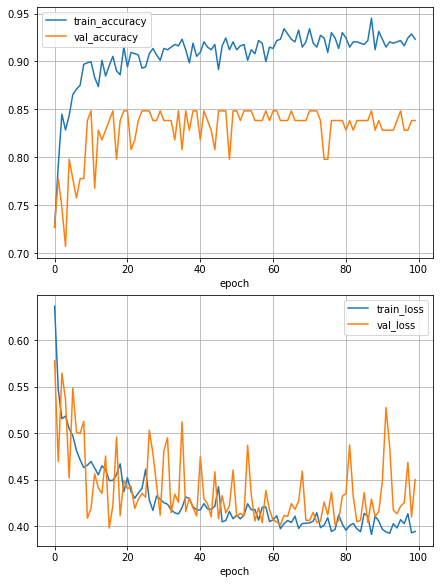

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

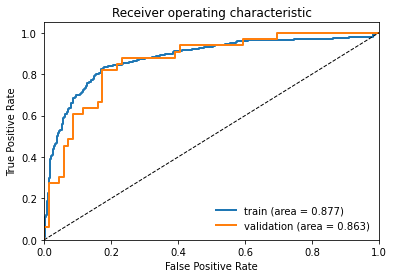

In [ ]:
bestmodel_file = os.path.join("model_ckpts", "bestmodel_gat.ckpt")
model = GATNet.load_from_checkpoint(bestmodel_file)
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [ ]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.85
auc 0.9109000452284034
aupr 0.8633116727373681
f1 0.7457627118644068
precision 0.8461538461538461
recall 0.6666666666666666
